In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import nltk
import numpy as np
from argparse import ArgumentParser
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
from matplotlib import rcParams
import urllib.request
import zipfile
rcParams['axes.titlepad'] = 20 
rcParams['axes.labelpad'] = 15
%matplotlib inline

In [2]:
os.chdir('../models')
os.getcwd()

'/scratch/jmw784/nlp-multinli/models'

In [3]:
from models import ConcatModel, CosineModel, ESIM

sys.path.append('../utilities')
from tokenizers import custom_tokenizer
from utils import get_dataset, get_args

# Loading arguments

If you want to get the config from the slurm file

In [4]:
F = open('../slurm/main.slurm','r')
options = F.read().split('main.py ')[1].strip('\n')

Else, if you want to paste the args here:

In [5]:
options = '--cuda --save_model --model_type ESIM --max_vocab_size 15000 --n_epochs 15 --batch_size 64 --d_embed 300 --d_hidden 200 --n_layers 1 --lr 0.001 --dropout_emb 0.2 --dropout_rnn 0.0 --dropout_mlp 0.5 --word_vectors glove.6B.300d --bidir --dev_every 1550'

In [6]:
options = options.split(' ')
sys.argv = options
args = get_args()

In [7]:
args

Namespace(agg_d_hidden=100, agg_n_layers=1, batch_size=64, bidir=True, cuda=False, d_embed=300, d_hidden=200, dataset='multinli', dev_every=1550, dropout_emb=0.2, dropout_mlp=0.5, dropout_rnn=0.0, intra_sentence=False, load_model='', lr=0.001, max_vocab_size=15000, model_type='ESIM', mp_dim=15, n_epochs=15, n_layers=1, n_linear_layers=3, no_comet=False, save_model=True, sentence_len=None, val_set='val_matched', word_vectors='glove.6B.300d')

# Build datasets

In [8]:
nltk_path = os.getcwd() + '/nltk_data'
nltk.download('punkt', download_dir=nltk_path)
nltk.data.path.append(nltk_path)

[nltk_data] Downloading package punkt to /scratch/jmw784/nlp-
[nltk_data]     multinli/models/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Remember to delete your TSV if it doesn't have the pair_field in it yet!!!

In [9]:
text_field = data.Field(tokenize=custom_tokenizer,
                        fix_length=args.sentence_len,
                        unk_token='<**UNK**>')
label_field = data.Field(sequential=False, unk_token=None)
pair_field = data.RawField()

train = get_dataset(text_field, label_field, pair_field, 'train')
val_matched = get_dataset(text_field, label_field, pair_field, 'val_matched')
val_unmatched = get_dataset(text_field, label_field, pair_field, 'val_mismatched')

text_field.build_vocab(train, max_size=args.max_vocab_size)
label_field.build_vocab(train, val_matched, val_unmatched)

Creating Train Dataset
Creating Val_Matched Dataset
Creating Val_Mismatched Dataset


In [10]:
def sort_key(ex):
    return data.interleave_keys(len(ex.premise), len(ex.hypothesis))

In [11]:
device = -1
train_iter, val_iter_matched, val_iter_unmatched = data.BucketIterator.splits((train, val_matched, val_unmatched),
                                            batch_size=args.batch_size,
                                            shuffle = False,
                                            sort = True,
                                            sort_key = sort_key,
                                            device=device)

In [12]:
class_map = {0: 'entailment',
           1: 'contradiction',
           2: 'neutral'}

# Load model

In [13]:
saved_model = 'Model_ESIM_acc_73.0413_epoch_6_model.pt'
model = torch.load('../saved_models/' + saved_model)

/share/apps/pytorch/0.2.0_3/python3.5/lib/python3.5/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'models.ESIM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [14]:
model

ESIM (
  (embed): Embedding(15002, 200)
  (emb_drop): Dropout (p = 0.2)
  (dropout): Dropout (p = 0.5)
  (mlp): Linear (1600 -> 200)
  (cl): Linear (200 -> 3)
  (premise): LSTM(200, 200, bidirectional=True)
  (hypothesis): LSTM(200, 200, bidirectional=True)
  (v1): LSTM(1600, 200, bidirectional=True)
  (v2): LSTM(1600, 200, bidirectional=True)
)

In [15]:
def get_batch(data, batch_size, batch_size_fn=lambda new, count, sofar: count):
    """Yield elements from data in chunks of batch_size."""
    minibatch, size_so_far = [], 0
    for ex in data:
        minibatch.append(ex)
        size_so_far = batch_size_fn(ex, len(minibatch), size_so_far)
        if size_so_far == batch_size:
            yield minibatch
            minibatch, size_so_far = [], 0
        elif size_so_far > batch_size:
            yield minibatch[:-1]
            minibatch, size_so_far = minibatch[-1:], batch_size_fn(ex, 1, 0)
    if minibatch:
        yield minibatch

In [16]:
def evaluate(iterator, model):
    real_iter = get_batch(iterator.data(), args.batch_size)
    
    model.eval()
    n_correct = 0
    predictions = []
    labels = []
    
    premises = []
    hypothesises = []
    real_labels = []
    pair_ids = []
    
    for batch, real_batch in zip(iterator, real_iter):
        
        real_batch.reverse()
        out = model(batch)
        batch_predict = torch.max(out, 1)[1].view(batch.label.size()).data
        batch_label = batch.label.data
        n_correct += (batch_predict == batch_label).sum()
        predictions.extend(batch_predict.tolist())
        labels.extend(batch_label.tolist())
        
        premises.extend([x.premise for x in real_batch])
        hypothesises.extend([x.hypothesis for x in real_batch])
        real_labels.extend([x.label for x in real_batch])
        pair_ids.extend([x.pairID for x in real_batch])
                        
    return n_correct,\
           np.array(predictions), np.array(labels),\
           np.array(premises), np.array(hypothesises), np.array(real_labels), np.array(pair_ids)

In [17]:
def plot_confusion_matrix(true_values, predicted_values,
                          class_map = class_map,
                          classes = [0, 1, 2], 
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(true_values, predicted_values, labels = classes)

    fig, ax = plt.subplots(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, fontsize=16, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, [class_map[i] for i in classes])
    plt.yticks(tick_marks, [class_map[i] for i in classes])

    if normalize:
        cm = np.around(100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{0}%'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size='large')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.yaxis.label.set_size(14)
    ax.xaxis.label.set_size(14)


In [18]:
def print_samples(labels, predictions, premises, hypotheses, label, prediction, samples = 5):
    idx = np.logical_and(labels == label, predictions == prediction)
    n = np.sum(idx)
    
    selection = np.random.choice(range(n), size=samples)
    
    p = premises[idx][selection]
    h = hypotheses[idx][selection]
    
    print('TRUE LABEL: %s\nPREDICTION: %s\n' % (class_map[label], class_map[prediction]))
    
    for i in range(samples):
        print('Sample %s' % (i+1))
        print('Premise: ' + ' '.join(p[i]))
        print('Hypothesis: ' + ' '.join(h[i]))
        print('-------------------------------------------------------\n')

# Annotation analysis

In [20]:
url = 'http://www.nyu.edu/projects/bowman/multinli/multinli_1.0_annotations.zip'

if not os.path.exists('../data/multinli_1.0_annotations/'):
    print('Please download the annotations into the data folder from %s' % (url))

In [21]:
matched_file = 'multinli_1.0_matched_annotations.txt'
mismatched_file = 'multinli_1.0_mismatched_annotations.txt'
matched_annotations = {}
mismatched_annotations = {}

for filename, annotations in zip([matched_file, mismatched_file], [matched_annotations, mismatched_annotations]):
    
    with open('../data/multinli_1.0_annotations/' + filename, 'r') as f:
        for line in f:
            s = line.strip().split('\t')
            annotations[s[0]] = s[1:]

In [22]:
categories = ['#CONDITIONAL', '#ACTIVE/PASSIVE', '#PARAPHRASE', '#COREF',
             '#QUANTIFIER', '#MODAL', '#BELIEF', '#NEGATION', '#ANTO',
             '#TENSE_DIFFERENCE', '#QUANTITY/TIME_REASONING', '#WORD_OVERLAP',
             '#LONG_SENTENCE']

latex_categories = ['Conditional', 'Active / Passive', 'Paraphrase',
                    'Corefer', 'Quantifier', 'Modal', 'Belief', 'Negation',
                    'Antonym', 'Tense Difference', 'Quantity / Time',
                    'Word Overlap', 'Long Sentence']

# Results!

In [23]:
def results(val_name, val_iter, annotations, model):
    n_correct, predictions, labels, premises, hypotheses, real_labels, pair_ids = evaluate(val_iter, model)  
    accuracy = n_correct / len(val_iter_matched.dataset) * 100
    print("Accuracy: {0}".format(accuracy))
    
    sub_accs = []
    
    for category in categories:
        
        num_correct = 0
        total = 0
        
        for i in range(len(pair_ids)):
            if category in annotations.get(pair_ids[i], []):
                total += 1
                
                if predictions[i] == labels[i]:
                    num_correct += 1
                    
        print('%s\t%0.2f%%' % (category.strip('#'), num_correct/total*100))
        
        sub_accs.append(num_correct/total*100)
                
    
    plot_confusion_matrix(labels, predictions, title='%s - %s\nAccuracy: %0.2f%%'
                                                  % (args.model_type, val_name, accuracy))
    for i in range(2):
        for j in range(2):
            print_samples(labels, predictions, premises, hypotheses, i, j)
            
    return sub_accs

Accuracy: 73.0412633723892
CONDITIONAL	60.87%
ACTIVE/PASSIVE	93.33%
PARAPHRASE	80.00%
COREF	83.33%
QUANTIFIER	75.20%
MODAL	79.17%
BELIEF	75.76%
NEGATION	74.42%
ANTO	88.24%
TENSE_DIFFERENCE	78.43%
QUANTITY/TIME_REASONING	53.33%
WORD_OVERLAP	78.57%
LONG_SENTENCE	80.81%
Normalized confusion matrix
[[ 78.73   6.35  14.92]
 [ 14.07  70.03  15.9 ]
 [ 17.29  12.9   69.8 ]]
TRUE LABEL: entailment
PREDICTION: entailment

Sample 1
Premise: ooh that does get high yeah i mean
Hypothesis: that does increase , yeah .
-------------------------------------------------------

Sample 2
Premise: ( and yes , he has said a few things that can , with some effort , be construed as support for supply-side economics . )
Hypothesis: it would take some work to construe the things as support for supply-side economics .
-------------------------------------------------------

Sample 3
Premise: and uh the whole organization was targeting to replace whole life policies with a term life with annuity an annuity and uh

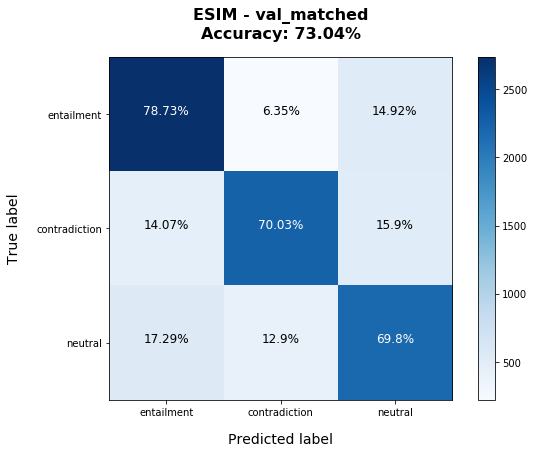

In [24]:
matched_accs = results('val_matched', val_iter_matched, matched_annotations, model)

Accuracy: 72.32806928171168
CONDITIONAL	65.38%
ACTIVE/PASSIVE	100.00%
PARAPHRASE	86.84%
COREF	76.67%
QUANTIFIER	72.14%
MODAL	71.43%
BELIEF	69.49%
NEGATION	67.31%
ANTO	85.00%
TENSE_DIFFERENCE	61.11%
QUANTITY/TIME_REASONING	50.00%
WORD_OVERLAP	75.68%
LONG_SENTENCE	70.64%
Normalized confusion matrix
[[ 80.94   5.11  13.95]
 [ 15.06  67.96  16.98]
 [ 20.01  13.07  66.92]]
TRUE LABEL: entailment
PREDICTION: entailment

Sample 1
Premise: on reflection , the parts will hold together .
Hypothesis: the part will hold together on second thought .
-------------------------------------------------------

Sample 2
Premise: these funds would insure that scholarships are available to students as long as there are students to support .
Hypothesis: the funds are planned to be used to help students
-------------------------------------------------------

Sample 3
Premise: the iupui challenger scholars are chosen from among outstanding students in the humanities , sciences , technologies and education wh

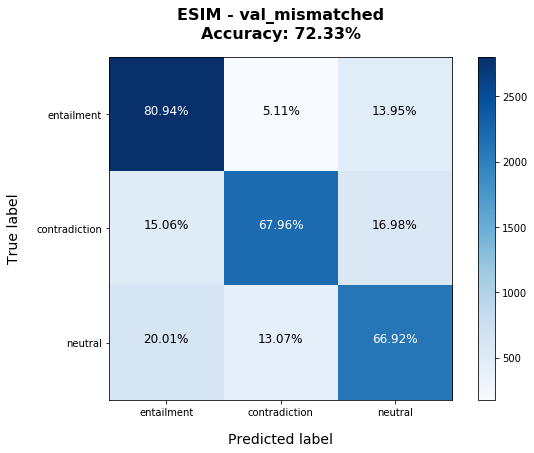

In [25]:
mismatched_accs = results('val_mismatched', val_iter_unmatched, mismatched_annotations, model)

# Because I know you're lazy: LaTeX table!

In [34]:
latex = """\\begin{tabular}{l | c | c}
\\textbf{Category} & Matched (\%) & Mismatched (\%) \\\\
\hline \\\\
"""

for i in range(len(latex_categories)):
    latex += latex_categories[i] + ' & %.2f & %.2f \\\\ \n' % (matched_accs[i], mismatched_accs[i])

latex += '\end{tabular}'

print(latex)

\begin{tabular}{l | c | c}
\textbf{Category} & Matched (\%) & Mismatched (\%) \\
\hline \\
Conditional & 60.87 & 65.38 \\ 
Active / Passive & 93.33 & 100.00 \\ 
Paraphrase & 80.00 & 86.84 \\ 
Corefer & 83.33 & 76.67 \\ 
Quantifier & 75.20 & 72.14 \\ 
Modal & 79.17 & 71.43 \\ 
Belief & 75.76 & 69.49 \\ 
Negation & 74.42 & 67.31 \\ 
Antonym & 88.24 & 85.00 \\ 
Tense Difference & 78.43 & 61.11 \\ 
Quantity / Time & 53.33 & 50.00 \\ 
Word Overlap & 78.57 & 75.68 \\ 
Long Sentence & 80.81 & 70.64 \\ 
\end{tabular}
